# Live Transcriber (sounddevice version)
This script is for finding the Scarlett and recording audio from it. It will then transcribe the audio and save the text to a csv file in real time.

It also implements multithreading so that the recording and transcription can happen simultaneously.


# Game Plan
- Only one recording thread. The thread is continuously listening and internally checks if each channel is speaking, with speaker status being independent between the channels. 
- At the end of a chunk on a given channel, the accumulated recording is then sent to a transcriber thread. 
- So, at any given time, only one recording thread is activated while a number of transcriber threads can be operating. 
- ThreadLock will be used to save data to .csv. 

In [1]:
import wave
import audioop
import os
import pandas as pd
import numpy as np
import time as tm
import whisper
from transcriber import transcribe
import threading
from pathlib import Path
import queue
import sounddevice as sd
from scipy.io.wavfile import write
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import pyaudio
from tqdm import tqdm

In [2]:
#find the Scarlett
devices = sd.query_devices()
device_index = None
for i, device_info in enumerate(devices):
    if "Scarlett" in device_info["name"] and device_info["max_input_channels"] > 0:
        device_index = i
        break

if device_index is None:
    raise RuntimeError("Could not find Scarlett device")
else:
    print(f'Using device {device_index}: {devices[device_index]["name"]}')

Using device 1: Scarlett 2i2 USB


In [3]:
CHANNELS = 2
global RATE
RATE = 16000
#global CHUNK
#CHUNK = 400
global BLOCKSIZE
BLOCKSIZE = 400
THRESHOLD = 0.05  # Adjust this value based on your microphone and environment
AUDIOFILE_PATH = '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs'
GAP = 2 # Length of silence allowed before cut
SESSION_TIME = 3 # number of mins the session can be
AUDIOFILE_PATH = '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs'
SESSION_ACTIVE = True
MINIMUM_UTTERANCE_LENGTH = 1 # in seconds
FORMAT = pyaudio.paInt16

# Setting up the callback
The `sounddevice` library can record by passing a callback function to the `sd.InputStream` stream. It is in the callback that you are doing the listening, speaking status detection, and writing of data. This will run continuously and pass chunks of audio to the transriber threads, which handle transcription and saving of the audio and text.

In [4]:
def rms(data):
    return np.sqrt(np.mean(np.square(data)))

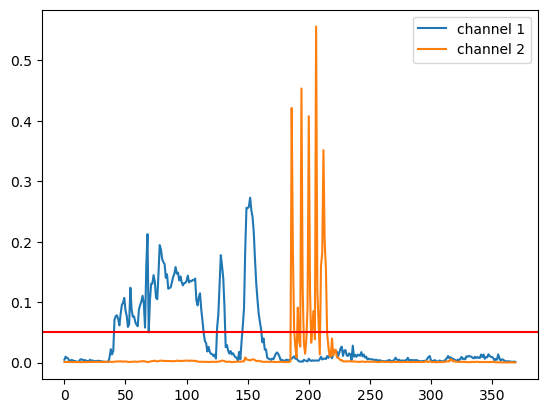

In [5]:
# record from channel 1 for 10 seconds to get rms values and then visualize them
rms_vals_1, rms_vals_2 = [], []
start = tm.time()
ch1_data, ch2_data = np.array([]), np.array([])
with sd.InputStream(channels=CHANNELS, device=device_index, blocksize=400, samplerate=RATE) as stream:
    while True:
        data = stream.read(400)[0]
        data1, data2 = data[:, 0], data[:, 1]
        ch1_data = np.concatenate((ch1_data, data1))
        ch2_data = np.concatenate((ch2_data, data2))
        rms_val1, rms_val2 = rms(data1), rms(data2)
        rms_vals_1.append(rms_val1)
        rms_vals_2.append(rms_val2)
        if tm.time() - start > 10:
            break

plt.plot(rms_vals_1, label='channel 1')
plt.plot(rms_vals_2, label='channel 2')
# plot a horizontal line at the threshold value
plt.axhline(y=THRESHOLD, color='r', linestyle='-')
plt.legend()
plt.show()
sd.play(ch1_data, RATE)
tm.sleep(10)
sd.stop()
sd.play(ch2_data, RATE)
tm.sleep(10)
sd.stop()

In [5]:
transcripts = {}
global transcription_queue
transcription_queue = queue.Queue()
transcript_queue = []

# Writing the RecorderThread
This works. However, `whisper` automatically tries to use all the cores on the CPU by default. This makes things pretty slow. If I could set a parameter such that it only tries to use three, that'd be sick. 

In [10]:
class RecorderThread(threading.Thread):
    def __init__(self):
        super(RecorderThread, self).__init__()
        self.channel1_recording, self.channel2_recording = False, False
        self.ch1_data, self.ch2_data = np.array([]), np.array([])
        self.ch1_last, self.ch2_last = tm.time(), tm.time()
        self.ch1_start, self.ch2_start = None, None

    def record_dyad(self, indata, frames, time, status=None):
        # Get channel data and calulate RMS for each channel separately
        channel1_rms, channel2_rms = rms(indata[:, 0]), rms(indata[:, 1])

        # channel 1 control block
        if channel1_rms > THRESHOLD:
            if self.channel1_recording == False:
                print('channel 1 recording')
                self.ch1_last = tm.time()
                self.channel1_recording = True
                self.ch1_start = tm.time()
                self.ch1_data = np.concatenate((self.ch1_data, indata[:, 0]))
            else:
                self.ch1_last = tm.time()
                self.ch1_data = np.concatenate((self.ch1_data, indata[:, 0]))
        else:
            if self.channel1_recording == True:
                if (tm.time() - self.ch1_last > GAP):
                    print('channel 1 recording over')
                    print('Chunk duration = ', tm.time() - self.ch1_start)
                    self.channel1_recording = False
                    packet = {'channel': 1, 'data': self.ch1_data, 'start_time': self.ch1_start, 'end_time': self.ch1_last}
                    self.ch1_data = np.array([])
                    #transcription_queue.put(packet)
                    transcript_queue.append(packet)
                    self.ch1_start, self.ch1_last = None, None
                    print(f'Files in queue: {len(transcript_queue)}')
                else:
                    self.ch1_data = np.concatenate((self.ch1_data, indata[:, 0]))
            else:
                pass

        # channel 2 control block
        if channel2_rms > THRESHOLD:
            if self.channel2_recording == False:
                print('channel 2 recording')
                self.ch2_last = tm.time()
                self.channel2_recording = True
                self.ch2_start = tm.time()
                self.ch2_data = np.concatenate((self.ch2_data, indata[:, 1]))
            else:
                self.ch2_last = tm.time()
                self.ch2_data = np.concatenate((self.ch2_data, indata[:, 1]))
        else:
            if self.channel2_recording == True:
                if (tm.time() - self.ch2_last > GAP):
                    print('channel 2 recording over')
                    print('Chunk duration = ', tm.time() - self.ch2_start)
                    self.channel2_recording = False
                    packet = {'channel': 2, 'data': self.ch2_data, 'start_time': self.ch2_start, 'end_time': self.ch2_last}
                    self.ch2_data = np.array([])
                    #transcription_queue.put(packet)
                    transcript_queue.append(packet)
                    self.ch2_start, self.ch2_last = None, None
                else:
                    self.ch2_data = np.concatenate((self.ch2_data, indata[:, 1]))
            else:
                pass

    def run(self):
        with sd.InputStream(channels=CHANNELS, device=device_index, callback=self.record_dyad, blocksize=400, samplerate=RATE):
            while True:
                # run until the session is over
                if SESSION_ACTIVE == False:
                    print('session over')       
                    break

In [7]:
global n_utterances
n_utterances = 0
def process_transcription(data_dict):
    # do nothing if the audio is too short
    global n_utterances
    n_utterances += 1
    # save audio file to disk
    wt = tm.time()
    filename = f'utterance_{n_utterances}.wav'
    filepath = os.path.join(AUDIOFILE_PATH, filename)
    write(filepath, RATE, data_dict['data'])
    print('write took ', tm.time() - wt)
    data_dict['filepath'] = filepath
    t_start = tm.time()
    transcription = transcribe(filepath)
    print('transcription took ', tm.time() - t_start)
    data_dict['transcription'] = transcription
    # delete the audio data from the data_dict
    del data_dict['data']
    return n_utterances, data_dict

In [11]:
# trying a while loop setup
SESSION_ACTIVE = True
transcripts = {}
recorder = RecorderThread()
recorder.start()
mins = 1
start = tm.time()
while True:
    if tm.time() - start > mins * 60:
        SESSION_ACTIVE = False
        break
    else:
        for i, packet in enumerate(transcript_queue):
            n_utterances, data_dict = process_transcription(packet)
            print(f'Utterance {n_utterances}: {data_dict["transcription"]}')
            transcripts[n_utterances] = data_dict
            transcript_queue.pop(i)

channel 1 recording
channel 1 recording over
Chunk duration =  3.1705591678619385
write took  0.04287886619567871
transcription took  11.410557985305786
Files in queue: 2
channel 1 recording
channel 1 recording over
Chunk duration =  4.201894998550415
write took  0.026457786560058594
transcription took  14.310055255889893
Files in queue: 3


In [9]:
transcripts

{1: {'channel': 1,
  'start_time': 1699296691.0747452,
  'end_time': 1699296696.8512099,
  'filepath': '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs/utterance_1.wav',
  'transcription': 'beginning to become suspicious that whisper is actually using multiple threads in the background.'},
 2: {'channel': 1,
  'start_time': 1699296735.8201542,
  'end_time': 1699296736.5321898,
  'filepath': '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs/utterance_2.wav',
  'transcription': 'Why is this happening?'}}

In [8]:

# Function that will process the data
transcriptions = {}

def transcribe_data():
    # wait until there is something in the queue
    if transcription_queue.empty():
        while transcription_queue.empty():
            tm.sleep(0.1)
    try:
        utterance_dict = transcription_queue.get()
        if utterance_dict is None:
            pass
        else:
            t_start = tm.time()
            out = process_transcription(utterance_dict)
            t_end = tm.time()
            if not out:
                pass
            else:
                utter_n, utterance_info = out
                print(utterance_info['transcription'])
                print(f'Transcription THREAD took {t_end - t_start} seconds.')
                transcripts[utter_n] = utterance_info
        transcription_queue.task_done()
    except RuntimeError:
        print('\n\n################')
        print('Transcription failed.')
        print('Transcription queue size: ', transcription_queue.qsize())
        print(f'Data shape: {utterance_dict["data"].shape}')
        print(f'Channel: {utterance_dict["channel"]}')
        print(f'Start time: {utterance_dict["start_time"]}')
        print(f'End time: {utterance_dict["end_time"]}')
        print(f'Filepath: {utterance_dict["filepath"]}')
        print('################\n\n')
        transcription_queue.task_done()
        pass
    
SESSION_ACTIVE = True

# Number of worker threads
num_worker_threads = 3

# Create and start the data processing threads
workers = []
for i in range(num_worker_threads):
    t = threading.Thread(target=transcribe_data)
    t.start()
    workers.append(t)

recorder = RecorderThread()
recorder.start()

# wait 30 seconds then stop all the threads
print('Session started, begin sleeping.')
tm.sleep(30)
print('Ending session.')
SESSION_ACTIVE = False
recorder.join()
for t in tqdm(workers):
    t.join()
#transcription_queue.join()

# # Create a queue to communicate with the worker threads


    
# # Once done collecting data, join on the queue to allow processing to finish
# data_queue.join()

# # Stop the worker threads by putting None into the queue for each worker
# for i in range(num_worker_threads):
#     data_queue.put(None)
# for t in workers:
#     t.join()


Session started, begin sleeping.
channel 2 recording
channel 1 recording
channel 2 recording over
Chunk duration =  2.0755650997161865
channel 2 recording
channel 2 recording over
Chunk duration =  3.406399965286255
channel 1 recording over
Chunk duration =  10.170391082763672
putting packet took  2.4080276489257812e-05


################
Transcription failed.
Transcription queue size:  0
Data shape: (54800,)
Channel: 2
Start time: 1699287059.484556
End time: 1699287060.878691
Filepath: /Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs/utterance_2.wav
################


transcription took  12.275865077972412
So
Transcription THREAD took 12.309436321258545 seconds.
channel 1 recording
channel 2 recording
channel 2 recording over
Chunk duration =  2.1316092014312744
channel 1 recording over
Chunk duration =  7.929020166397095
putting packet took  1.3828277587890625e-05
Ending session.
session over


100%|██████████| 3/3 [00:00<00:00, 158.51it/s]

transcription took  16.27002191543579
So something happened on Mark's channel. So if I stop talking,
Transcription THREAD took 16.34054398536682 seconds.


In [9]:
# clear the queue 
while not transcription_queue.empty():
    transcription_queue.get()
    transcription_queue.task_done()

In [10]:
transcription_queue.empty()

True

In [9]:
transcripts

{3: {'channel': 1,
  'start_time': 1699287055.521131,
  'end_time': 1699287063.6734898,
  'filepath': '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs/utterance_3.wav',
  'transcription': "So something happened on Mark's channel. So if I stop talking,"}}

In [11]:
# record for 10 seconds and try to transcribe
recording = np.array([])
start = tm.time()
with sd.InputStream(channels=CHANNELS, device=device_index, blocksize=BLOCKSIZE, samplerate=RATE) as stream:
    while True:
        data = stream.read(400)[0]
        data = data[:, 0]
        recording = np.concatenate((recording, data))

        if tm.time() - start > 10:
            break

filename = 'test_utt.wav'
filepath = os.path.join(AUDIOFILE_PATH, filename)
write(filepath, RATE, recording)
t_start = tm.time()
transcription = transcribe(filepath)
t_end = tm.time()
print(f'Transcription: {transcription}')
print(f'Took {t_end - t_start} seconds to transcribe')

Transcription: big fun times. I really love cookies.
Took 0.9260609149932861 seconds to transcribe
